#### **1) Libraries**

In [1]:
# Don't forget to restart
# !pip install -U tensorflow_probability -q
!pip install ipdb tensorflow==2.5.0 -q
!pip install git+https://github.com/tensorflow/docs -q
# !pip install -U -i https://test.pypi.org/simple/ nsc -q

In [2]:
from IPython import display

import ipdb
import math
import glob
import imageio
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import numpy as np
import PIL
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import time
import os
import random
from tqdm import tqdm
from collections import defaultdict

from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.layers import Input, InputLayer, Lambda, Reshape, Dropout, \
                                    Flatten, Dense, Conv2D, Conv2DTranspose

# nsc and nsc-tf lib
# import nsc

In [3]:
pip list | grep tensorflow

tensorflow                    2.5.0
tensorflow-datasets           4.0.1
tensorflow-docs               0.0.0cefa2f092b60fa8b89a1fbea3d4f029b3bd65b9a-
tensorflow-estimator          2.5.0
tensorflow-gcs-config         2.5.0
tensorflow-hub                0.12.0
tensorflow-metadata           1.1.0
tensorflow-probability        0.13.0


In [4]:
if tf.test.gpu_device_name() != '/device:GPU:0':
    print('WARNING: GPU device not found.')
else:
    print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


In [5]:
# List all physical devices
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

If using Google Colab, save in your Google Drive.

In [6]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#### **2) Extract Data**

In [7]:
BATCH_SIZE = 5000  # 32 128

# datasets_names = ['mnist', 'mnist_corrupted', 'fashion_mnist', 'cifar10', 'cifar10_corrupted']
datasets_names = ['mnist']

In [8]:
def _preprocess(sample):
    image = tf.cast(sample['image'], tf.float32) / 255.  # Scale to unit interval.
    return image

def _preprocess_label(sample):
    label = tf.cast(sample['label'], tf.int32)
    return label

In [9]:
def get_datasets(datasets_names, batch_size):
    datasets = defaultdict(dict)
    for datasets_name in datasets_names:
        print(f"============================================================================================")
        print(f"\nExtracting {datasets_name.upper()} dataset...\n")
        datasets_raw, datasets_raw_info = tfds.load(name=datasets_name,
                                                    with_info=True,
                                                    as_supervised=False
                                                    )
        print(datasets_raw_info)

        # View some examples from the dataset
        fig, axes = plt.subplots(3, 3, figsize=(8, 8))
        fig.subplots_adjust(hspace=0.2, wspace=0.1)
        for i, (elem, ax) in enumerate(zip(datasets_raw['train'], axes.flat)):
            image = tf.squeeze(elem['image'])
            # print(image)
            label = elem['label']

            ax.imshow(image, cmap='gray')
            ax.text(0.7, -0.12, f'Digit = {label}', ha='right',
                    transform=ax.transAxes, color='black')
            ax.set_xticks([])
            ax.set_yticks([])
            # plt.show()

        # Get
        train_size = 60000 if 'mnist' in datasets_name else 50000
        if 'corrupted' not in datasets_name:
            datasets[datasets_name]['train'] = (datasets_raw['train']
                                                .map(_preprocess)
                                                .batch(batch_size)
                                                .prefetch(tf.data.experimental.AUTOTUNE)
                                                .shuffle(train_size)
                                                )
        datasets[datasets_name]['test'] = (datasets_raw['test']
                                           .map(_preprocess)
                                           .batch(batch_size)
                                           .prefetch(tf.data.experimental.AUTOTUNE)
                                           )
        datasets[datasets_name]['test_label'] = (datasets_raw['test']
                                                 .map(_preprocess_label)
                                                 .batch(batch_size)
                                                 .prefetch(tf.data.experimental.AUTOTUNE)
                                                 )

        if 'corrupted' not in datasets_name:
            #
            print(" - Print one train set image:")
            for train_batch in datasets[datasets_name]['train'].take(1):
                image = train_batch[0].numpy()
            image = np.squeeze(image)
            plt.figure()
            plt.imshow(image, cmap='gray')
            plt.colorbar()
            plt.grid(False)
            plt.axis('off')
            plt.show();

        #
        print(" - Print one test set image:")
        for test_batch in datasets[datasets_name]['test'].take(1):
            image = test_batch[0].numpy()
        image = np.squeeze(image)
        plt.figure()
        plt.imshow(image, cmap='gray')
        plt.colorbar()
        plt.grid(False)
        plt.axis('off')
        plt.show();

        #
        print(" - Print one test set label:")
        for test_label in datasets[datasets_name]['test_label'].take(1):
            label = test_label[0]
        print(label.numpy())
        print(f"\n")

    return datasets


Extracting MNIST dataset...

tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.1,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)

 - Print one train set image:


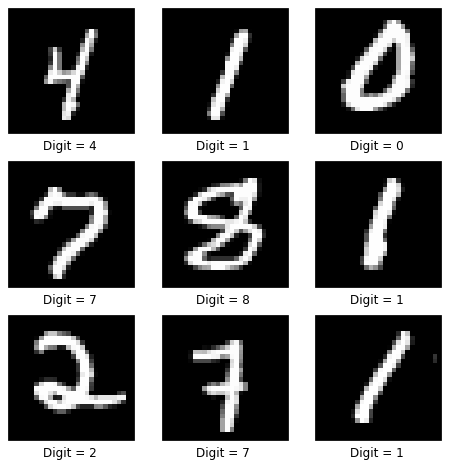

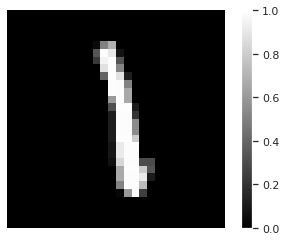

 - Print one test set image:


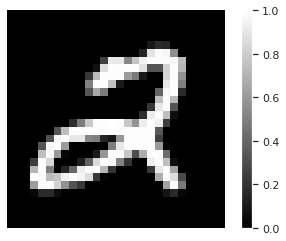

 - Print one test set label:
2


CPU times: user 8.37 s, sys: 3.76 s, total: 12.1 s
Wall time: 4.29 s


In [10]:
%%time
datasets = get_datasets(datasets_names, BATCH_SIZE)

FashionMNIST item mapping:

In [11]:
'''
0	T-shirt/top
1	Trouser
2	Pullover
3	Dress
4	Coat
5	Sandal
6	Shirt
7	Sneaker
8	Bag
9	Ankle boot
'''

'\n0\tT-shirt/top\n1\tTrouser\n2\tPullover\n3\tDress\n4\tCoat\n5\tSandal\n6\tShirt\n7\tSneaker\n8\tBag\n9\tAnkle boot\n'

CIFAR-10 item mapping:

In [12]:
'''
0	airplane
1	automobile
2	bird
3	cat
4	deer
5	dog
6	frog
7	horse
8	ship
9	truck boot
'''

'\n0\tairplane\n1\tautomobile\n2\tbird\n3\tcat\n4\tdeer\n5\tdog\n6\tfrog\n7\thorse\n8\tship\n9\ttruck boot\n'

#### **3) Model Class**

Credit: https://www.tensorflow.org/api_docs/python/tf/keras/datasets

In [13]:
from tensorflow.keras import layers as tfkl

In [14]:
class Sampler_Z(tfkl.Layer):

    def call(self, inputs):
        mean, logvar = inputs
        # Reparameterize
        eps = tf.random.normal(shape=mean.shape, seed=0)
        z_sample = eps * tf.exp(logvar * .5) + mean
        return z_sample

In [15]:
# Encoder/Decoder layers 1 (for MNIST images)
class EncoderZ_1(tfkl.Layer):

    def __init__(self, latent_dim, n_filter_base, name="encoder", **kwargs):
        super(EncoderZ_1, self).__init__(name=name, **kwargs)
        # Block-1
        self.conv_layer_1 = tfkl.Conv2D(filters=n_filter_base, kernel_size=3,
                                        strides=1, padding='same', name='conv_1'
                                        )
        self.batch_layer_1 = tfkl.BatchNormalization(name='bn_1')
        self.activation_layer_1 = tfkl.Activation(tf.nn.leaky_relu, name='lrelu_1')
        # Block-2
        self.conv_layer_2 = tfkl.Conv2D(filters=n_filter_base*2, kernel_size=3,
                                        strides=2, padding='same', name='conv_2'
                                        )
        self.batch_layer_2 = tfkl.BatchNormalization(name='bn_2')
        self.activation_layer_2 = tfkl.Activation(tf.nn.leaky_relu, name='lrelu_2')
        # Block-3
        self.conv_layer_3 = tfkl.Conv2D(filters=n_filter_base*2, kernel_size=3,
                                        strides=2, padding='same', name='conv_3'
                                        )
        self.batch_layer_3 = tfkl.BatchNormalization(name='bn_3')
        self.activation_layer_3 = tfkl.Activation(tf.nn.leaky_relu, name='lrelu_3')
        # Block-4
        self.conv_layer_4 = tfkl.Conv2D(filters=n_filter_base*2, kernel_size=3,
                                        strides=1, padding='same', name='conv_4'
                                        )
        self.batch_layer_4 = tfkl.BatchNormalization(name='bn_4')
        self.activation_layer_4 = tfkl.Activation(tf.nn.leaky_relu, name='lrelu_4')
        # Final Block
        self.flatten_layer = Flatten()
        self.dense_mean = Dense(latent_dim, activation=None, name='z_mean')
        self.dense_raw_stddev = Dense(latent_dim, activation=None,
                                      name='z_raw_stddev'
                                      )
        self.sampler_z = Sampler_Z()

    # Functional
    def call(self, x_input):
        z = self.conv_layer_1(x_input)
        z = self.batch_layer_1(z)
        z = self.activation_layer_1(z)
        z = self.conv_layer_2(z)
        z = self.batch_layer_2(z)
        z = self.activation_layer_2(z)
        z = self.conv_layer_3(z)
        z = self.batch_layer_3(z)
        z = self.activation_layer_3(z)
        z = self.conv_layer_4(z)
        z = self.batch_layer_4(z)
        z = self.activation_layer_4(z)
        z = self.flatten_layer(z)
        mean = self.dense_mean(z)
        logvar = self.dense_raw_stddev(z)
        z_sample = self.sampler_z((mean, logvar))
        return z_sample, mean, logvar


class DecoderX_1(tfkl.Layer):

    def __init__(self, latent_dim, n_filter_base, name="decoder", **kwargs):
        super(DecoderX_1, self).__init__(name=name, **kwargs)
        # For MNIST images
        self.dense_z_input = tfkl.Dense(units=7*7*n_filter_base*2,
                                        activation=tf.nn.relu
                                        )
        self.reshape_layer = tfkl.Reshape(target_shape=(7, 7, n_filter_base*2))
        # Block-1
        self.conv_transpose_layer_1 = tfkl.Conv2DTranspose(filters=n_filter_base*2,
                                                           kernel_size=3,
                                                           strides=1, 
                                                           padding='same',
                                                           name='conv_transpose_1'
                                                           )
        self.batch_layer_1 = tfkl.BatchNormalization(name='bn_1')
        self.activation_layer_1 = tfkl.Activation(tf.nn.leaky_relu, name='lrelu_1')
        # Block-2
        self.conv_transpose_layer_2 = tfkl.Conv2DTranspose(filters=n_filter_base*2,
                                                           kernel_size=3,
                                                           strides=2, 
                                                           padding='same',
                                                           name='conv_transpose_2'
                                                           )
        self.batch_layer_2 = tfkl.BatchNormalization(name='bn_2')
        self.activation_layer_2 = tfkl.Activation(tf.nn.leaky_relu, name='lrelu_2')
        # Block-3
        self.conv_transpose_layer_3 = tfkl.Conv2DTranspose(filters=n_filter_base,
                                                           kernel_size=3,
                                                           strides=2, 
                                                           padding='same',
                                                           name='conv_transpose_3'
                                                           )
        self.batch_layer_3 = tfkl.BatchNormalization(name='bn_3')
        self.activation_layer_3 = tfkl.Activation(tf.nn.leaky_relu, name='lrelu_3')
        # Block-4
        # Filters=1 for gray-scaled images
        self.conv_transpose_layer_4 = tfkl.Conv2DTranspose(filters=1,
                                                           kernel_size=3,
                                                           strides=1, 
                                                           padding='same',
                                                           name='conv_transpose_4'
                                                           )

    # Functional
    def call(self, z):
        x_output = self.dense_z_input(z)
        x_output = self.reshape_layer(x_output)
        x_output = self.conv_transpose_layer_1(x_output)
        x_output = self.batch_layer_1(x_output)
        x_output = self.activation_layer_1(x_output)
        x_output = self.conv_transpose_layer_2(x_output)
        x_output = self.batch_layer_2(x_output)
        x_output = self.activation_layer_2(x_output)
        x_output = self.conv_transpose_layer_3(x_output)
        x_output = self.batch_layer_3(x_output)
        x_output = self.activation_layer_3(x_output)
        x_output = self.conv_transpose_layer_4(x_output)
        return x_output

In [16]:
class VAEModel(tfk.Model):
    """Convolutional variational autoencoder base model."""

    def __init__(self, latent_dim, n_filter_base, seed):
        super(VAEModel, self).__init__()
        self.encoder = EncoderZ_1(latent_dim, n_filter_base)
        self.decoder = DecoderX_1(latent_dim, n_filter_base)

    @tf.function
    def sample(self, z_sample):
        x_recons_logits = self.decoder(z_sample)
        sample_images = tf.sigmoid(x_recons_logits)  # predictions
        return sample_images

    def call(self, x_input):
        z_sample, mean, logvar = self.encoder(x_input)
        x_recons_logits = self.decoder(z_sample)
        return x_recons_logits, z_sample, mean, logvar


In [17]:
# Display functions
class Visualize:

    def __init__(self, sample_func, z_sample, sample_labels,
                 overall_values, kl_divergence, display_path='.'
                 ):
        self.sample_func = sample_func
        self.z_sample = z_sample
        self.sample_labels = sample_labels
        self.overall_values = overall_values
        self.kl_divergence = kl_divergence
        self.display_path = display_path
        if len(z_sample) <= 16:
            sample_images = sample_func(z_sample)  # predictions
        else:
            sample_images = sample_func(z_sample)[:16]  # first 16 predictions
        self.sample_images = sample_images
        self.digit_size = len(sample_images[0])

    def display(self, show=True, **kwargs):
        self.display_generated_images(show=show, **kwargs)
        self.display_latent_space(show=show, **kwargs)
        self.display_manifold(show=show, **kwargs)
        self.display_histogram(show=show, **kwargs)

    def display_generated_images(self, image_size=4, show=True, **kwargs):
        fig = plt.figure(figsize=(image_size, image_size))
        for i in range(self.sample_images.shape[0]):
            plt.subplot(4, 4, i + 1)
            plt.imshow(self.sample_images[i, :, :, 0], cmap='gray')
            plt.axis('off')
        # tight_layout minimizes the overlap between 2 sub-plots
        plt.axis('Off')
        plt.savefig(f"{self.display_path}/generated_images/" + \
                    f"{self._picture_name('images', **kwargs)}"
                    )
        if show:
            plt.show();

    def display_latent_space(self, image_size=4, show=True, **kwargs):
        # display a 2D plot of the digit classes in the latent space
        colors = ['pink', 'red', 'orange', 'yellow', 'green',
                    'blue', 'purple', 'brown', 'gray', 'black'
                    ]
        plt.figure(figsize=(image_size, image_size))
        plt.scatter(self.z_sample[:, 0], self.z_sample[:, 1], c=self.sample_labels,
                    cmap=matplotlib.colors.ListedColormap(colors)
                    )
        plt.colorbar()
        plt.xlabel('z[0]')
        plt.ylabel('z[1]')
        plt.savefig(f"{self.display_path}/latent_spaces/" + \
                    f"{self._picture_name('latent', **kwargs)}"
                    )
        if show:
            plt.show();

    def display_manifold(self, n=20, image_size=10, show=True, **kwargs):
        """Plots n x n digit images decoded from the latent space."""
        norm = tfp.distributions.Normal(0, 1)
        grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
        grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
        image_width = self.digit_size*n
        image_height = image_width
        image = np.zeros((image_height, image_width))
        for i, yi in enumerate(grid_x):
            for j, xi in enumerate(grid_y):
                z = np.array([[xi, yi]])
                x_decoded = self.sample_func(z)
                digit = tf.reshape(x_decoded[0], 
                                   (self.digit_size, self.digit_size)
                                   )
                image[i*self.digit_size: (i+1)*self.digit_size,
                      j*self.digit_size: (j+1)*self.digit_size] = digit.numpy()
        plt.figure(figsize=(image_size, image_size))
        plt.imshow(image, cmap='Greys_r')
        plt.axis('Off')
        plt.savefig(f"{self.display_path}/manifolds/" + \
                    f"{self._picture_name('mani', **kwargs)}"
                    )
        if show:
            plt.show();

    def display_histogram(self, image_size=(24, 10), show=True, **kwargs):
        # Retrieve the generalized means and metric values
        log_prob_values = self.overall_values
        self._save_generalized_mean_metrics(log_prob_values)
        # log_prob_values = nsc.log_gmean(self.marginal_likelihood.numpy())
        # The histogram of the data
        fig, ax = plt.subplots(figsize=(24, 10))
        xtick_labels = ['1e-240', '1e-210', '1e-180', '1e-150', '1e-120', '1e-90', '1e-60', '1e-30', '1']
        ax.set_xticks([math.log(1e-240), math.log(1e-210), math.log(1e-180), math.log(1e-150), math.log(1e-120), math.log(1e-90), math.log(1e-60), math.log(1e-30), math.log(1)])
        ax.set_xticklabels(xtick_labels)
        plt.title('Histogram for Coupled VAE', fontdict = {'fontsize' : 40, 'weight': 'bold'})
        plt.xlabel('Probability of reconstructed image equivalent to original one.', fontdict = {'fontsize' : 40, 'weight': 'bold'})
        plt.ylabel('Frequency in logscale.', fontdict = {'fontsize' : 40, 'weight': 'bold'})
        # Plot in logscale, so convert the metric as logs as well
        plt.axvline(np.log(self.decisiveness), color='r', linestyle='dashed', linewidth=2)
        plt.axvline(np.log(self.accuracy), color='b', linestyle='dashed', linewidth=2)
        plt.axvline(np.log(self.robustness), color='g', linestyle='dashed', linewidth=2)
        plt.hist(log_prob_values, log=True, bins=100, facecolor='white', edgecolor='black')
        plt.savefig(f"{self.display_path}/histograms/" + \
                    f"{self._picture_name('hist', **kwargs)}"
                    )
        if show:
            plt.show();

    def _save_generalized_mean_metrics(self, log_prob_values):
        # Save the generalized means and metric values
        prob_values = tf.exp(log_prob_values)
        self.inv_n = 1 / len(prob_values)  # 1/n
        self.decisiveness = self._calculate_decisiveness(prob_values)
        self.accuracy = self._calculate_accuracy(prob_values)
        self.robustness = self._calculate_robustness(prob_values)

    def _calculate_decisiveness(self, values):
        # Decisiveness = Arithmetic mean
        result = tf.reduce_sum(values) * self.inv_n
        # result = sum(overall_values) / float(len(overall_values))
        return result.numpy()

    def _calculate_accuracy(self, values):
        # Accuracy = Geometric mean
        result = tf.reduce_prod(values ** self.inv_n)
        # result = 1
        # for x in values: 
            # temp = x ** (1/float(len(overall_values))) 
            # result = result * temp
        return result.numpy()

    def _calculate_robustness(self, values):
        # Robustness = -2/3 Mean
        result = tf.reduce_sum(values ** (-2/3))
        result = (result * self.inv_n) ** (-3/2)
        # result = 0
        # for x in prob_values:
        #     result = result + (x ** (-2/3))
        # result = (result / float(len(values))) ** (-3/2)
        return result.numpy()

    def _picture_name(self, display_type, **kwargs):
        name = display_type
        for key, value in kwargs.items():
            name += f'_{key}{str(value)}'
        return f'{name}.png'

    def get_generalized_mean_metrics(self):
        print(f"Decisiveness (Arithmetic Mean): {self.decisiveness:.4e}")
        print(f"Accuracy (Geometric Mean): {self.accuracy:.4e}")
        print(f"Robustness (-2/3 Mean): {self.robustness:.4e}")
        return self.decisiveness, self.accuracy, self.robustness


In [18]:
class VAE:
    """Variational Autoencoder wrapper."""
    def __init__(self, image_dim, z_dim, n_filter_base=32, 
                 learning_rate=0.0005, beta=1., p_std=1., seed=0,
                 display_path='.'
                 ):
        self.optimizer = tfk.optimizers.Adam(learning_rate)
        self.model = VAEModel(z_dim, n_filter_base, seed)
        self.metrics = defaultdict(list)
        self.beta = beta
        self.p_std = p_std
        self.display_path = display_path
        self.set_random_seeds(seed)

    def train(self, train_dataset, test_dataset, test_label, batch_size=0, 
              n_epoch=100, n_epoch_display=10, n_sample=4):
        # Pick a sample of the test set for generating output images
        # num_examples_to_generate = n_sample
        assert batch_size >= n_sample
        for test_batch, test_batch_label in zip(test_dataset.take(1),
                                                test_label.take(1)
                                                ):
            test_sample = test_batch[0:n_sample, :, :, :]
            test_sample_label = test_batch_label[0:n_sample]

        for epoch in range(1, n_epoch + 1):
            start_time = time.time()
            for train_x in tqdm(train_dataset):
                self.train_step(train_x)
            end_time = time.time()
            # Get Loss Metrics
            for test_x in test_dataset:
                loss, neg_ll, kl_div, ll_values = self.compute_loss(test_x)
            display.clear_output(wait=False)
            print(f"Epoch: {epoch}, Test set Loss: {loss}, " + \
                  f"Test set Recon: {neg_ll}, Test set KL: {kl_div}, " + \
                  f"time elapse for current epoch: {end_time - start_time}"
                  )
            # Save Loss Metrics for every epoch
            self.metrics['loss'].append(loss.numpy())
            self.metrics['recon_loss'].append(neg_ll.numpy())
            self.metrics['kl_div'].append(kl_div.numpy())
            # Visualize / Display
            if epoch % n_epoch_display == 0:
                z_sample, _, _ = self.model.encoder(test_sample)
                viz = Visualize(self.model.sample,
                                z_sample,
                                test_sample_label,
                                ll_values,  # overall_values = log_prob_values
                                kl_div,  # kl_divergence
                                self.display_path
                                )
                viz.display(cd='X',
                            cl='X',
                            epoch=epoch
                            )
                dec, acc, rob = viz.get_generalized_mean_metrics()
                # Save Loss Metrics for every <n_epoch_display> epoch
                self.metrics['decisiveness'].append(dec)
                self.metrics['accuracy'].append(acc)
                self.metrics['robustness'].append(rob)    

    @tf.function
    def train_step(self, x_true):
        """Executes one training step and returns the loss.

        This function computes the loss and gradients, and uses the latter to
        update the model's parameters.
        """
        with tf.GradientTape() as tape:
            loss = self.compute_loss(x_true, True)
        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

    def log_normal_pdf(self, sample, mean, logvar, raxis=1):
        log2pi = tf.math.log(2. * np.pi)
        return tf.reduce_sum(
            -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
            axis=raxis)

    def compute_loss(self, x_true, train=False):
        x_recons_logits, z_sample, mean, logvar = self.model(x_true)
        # Sigmoid Cross Entropy Loss 
        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_recons_logits,
                                                            labels=x_true
                                                            )
        # Negative Log-Likelihood
        logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])  # log-likelihood
        neg_ll = -logpx_z  # negative log-likelihood
        # KL-Divergence
        logpz = self.log_normal_pdf(z_sample, 0., self.p_std)
        logqz_x = self.log_normal_pdf(z_sample, mean, logvar)
        kl_div = logqz_x - logpz
        # ELBO
        neg_ll_mean = tf.math.reduce_mean(neg_ll)
        kl_div_mean = tf.math.reduce_mean(kl_div)
        # elbo = -self.beta*kl_div_mean + neg_ll_mean
        loss = neg_ll_mean + self.beta*kl_div_mean
        if train:
            return loss
        return loss, neg_ll_mean, kl_div_mean, tf.cast(logpx_z, tf.float64)

    def set_random_seeds(self, seed):
        tf.random.set_seed(seed)
        np.random.seed(seed)
        random.seed(seed)


#### **4) Models Train**

In [19]:
datasets['mnist']['train'], datasets['mnist']['test']

(<ShuffleDataset shapes: (None, 28, 28, 1), types: tf.float32>,
 <PrefetchDataset shapes: (None, 28, 28, 1), types: tf.float32>)

In [20]:
# datasets['cifar10']['train'], datasets['cifar10']['test']

In [21]:
# vae init params
input_dim = 28  # image dim
image_dim = (28, 28, 1)
# image_dim = (224, 224, 3)
z_dim = 2  # latent dim, set the dimensionality of the latent space to a plane for visualization later
n_filter_base = 32  # number of base filters in the CNN (a lot of filters?)
learning_rate = 0.0005  # uses for the internal Adam opt
# vae.train params
n_epoch = 500  # 100 number of epochs
n_epoch_display = 100  # 10 number of epochs before displaying plots
batch_size = BATCH_SIZE
show_display = True
display_sample = False
n_sample = BATCH_SIZE  #16  # number of example outputs to sample and generate, also n_display
seed = 0
beta_list = [float(i) for i in range(1, 2)]  # VAE beta
# p_std_list = [float(i) for i in range(1, 5)]  # prior std
# beta_list = [i/10. for i in range(10, 30+2, 2)]  # VAE beta
# p_std_list = [i/10. for i in range(10, 30+2, 2)]  # prior std
# set path to your specified Drive directory
save_path = 'gdrive/My Drive/Colab Notebooks/coupled_vae/vae/output/v4.2'
# display_path = save_path + '/display'
display_path = save_path

In [22]:
beta_vae_list = {}
prior_vae_list = {}

Epoch: 500, Test set Loss: 144.70703125, Test set Recon: 138.32054138183594, Test set KL: 6.386482238769531, time elapse for current epoch: 3.891620397567749


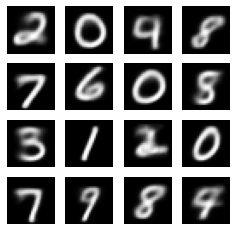

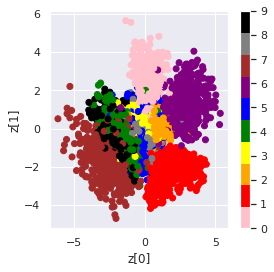

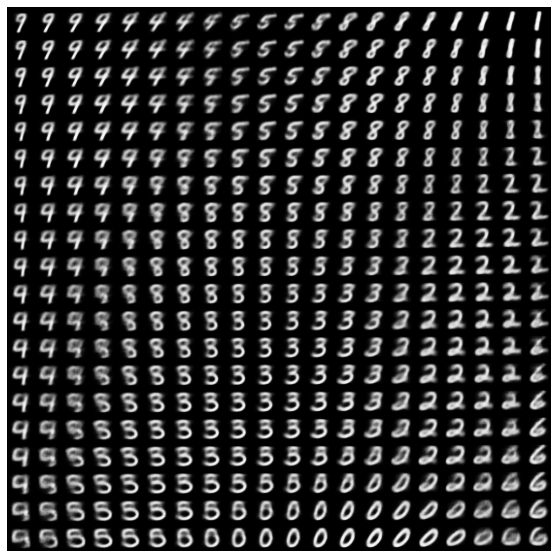

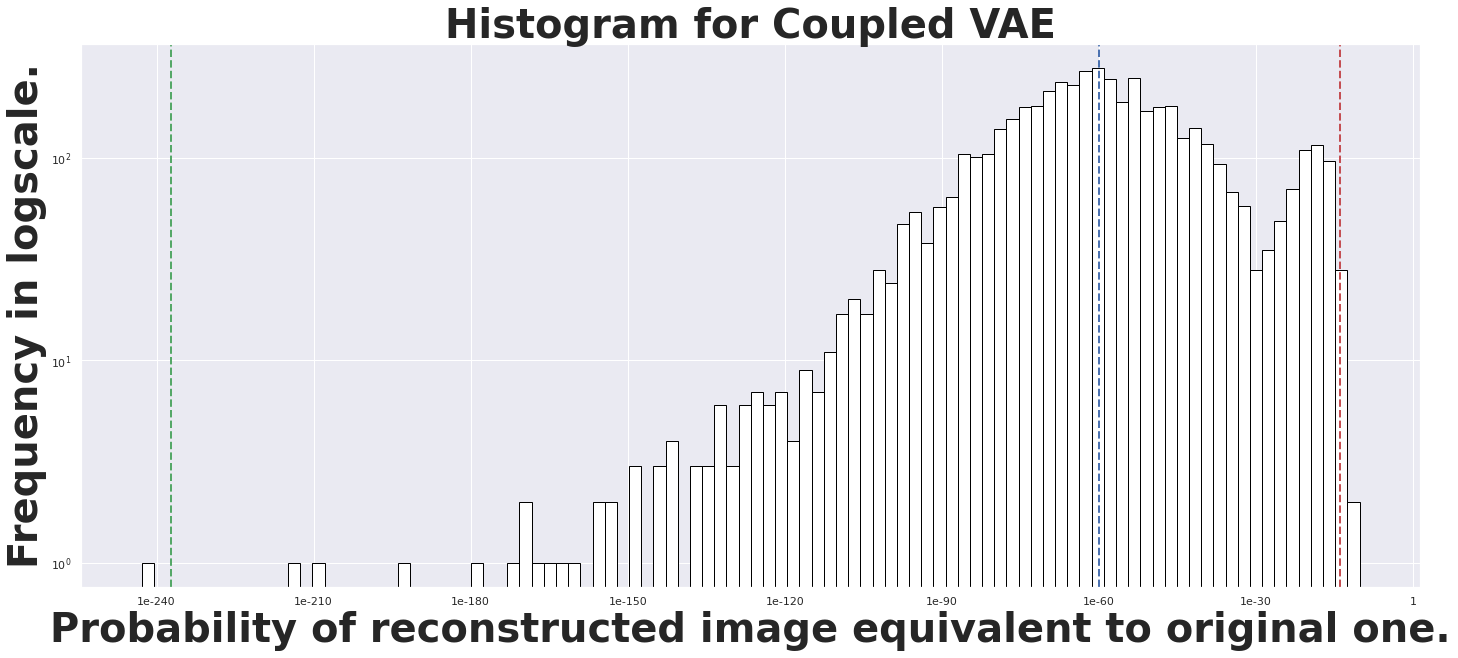

Decisiveness (Arithmetic Mean): 1.1696e-14
Accuracy (Geometric Mean): 8.4753e-61
Robustness (-2/3 Mean): 5.8579e-238
CPU times: user 19min 28s, sys: 8min 10s, total: 27min 39s
Wall time: 37min 14s


In [23]:
%%time
for beta in beta_list:
    beta_vae_list[beta] = VAE(image_dim,
                              z_dim,
                              beta=beta,
                              seed=seed,
                              display_path=display_path
                              )
    beta_vae_list[beta].train(datasets['mnist']['train'],
                              datasets['mnist']['test'],
                              datasets['mnist']['test_label'],
                              batch_size,
                              n_epoch,
                              n_epoch_display,
                              n_sample
                              )

In [24]:
# %%time
# for p_std in p_std_list:
#     prior_vae_list[p_std] = VAE(image_dim, z_dim, p_std=p_std)
#     prior_vae_list[p_std].train(datasets['mnist']['train'],
#                                 datasets['mnist']['test'],
#                                 datasets['mnist']['test_label'],
#                                 batch_size,
#                                 n_epoch,
#                                 n_sample,
#                                 )

In [25]:
beta_vae_list.keys()  # , prior_vae_list.keys()

dict_keys([1.0])

#### **5) Models Display**

Use vanilla VAE model with prior std = 1 as example

In [26]:
vae = beta_vae_list[1]

In [27]:
# def display_image(epoch_no):
#     return PIL.Image.open(f"{display_path}/generated_images/{_picture_name('images', epoch=epoch_no)}")
#     # return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [28]:
# plt.imshow(display_image(n_epoch))
# plt.axis('off')  # Display images

In [29]:
# anim_file = 'cvae.gif'

# with imageio.get_writer(anim_file, mode='I') as writer:
#     filenames = glob.glob('image*.png')
#     filenames = sorted(filenames)
#     for filename in filenames:
#         image = imageio.imread(filename)
#         writer.append_data(image)
#     image = imageio.imread(filename)
#     writer.append_data(image)

In [30]:
# import tensorflow_docs.vis.embed as embed
# embed.embed_file(anim_file)

In [31]:
def plot_latent_images(model, n, digit_size=28):
    """Plots n x n digit images decoded from the latent space."""
    norm = tfp.distributions.Normal(0, 1)
    grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
    grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
    image_width = digit_size*n
    image_height = image_width
    image = np.zeros((image_height, image_width))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z = np.array([[xi, yi]])
            x_decoded = model.sample(z)
            digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
            image[i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size] = digit.numpy()

    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('Off')
    plt.show();

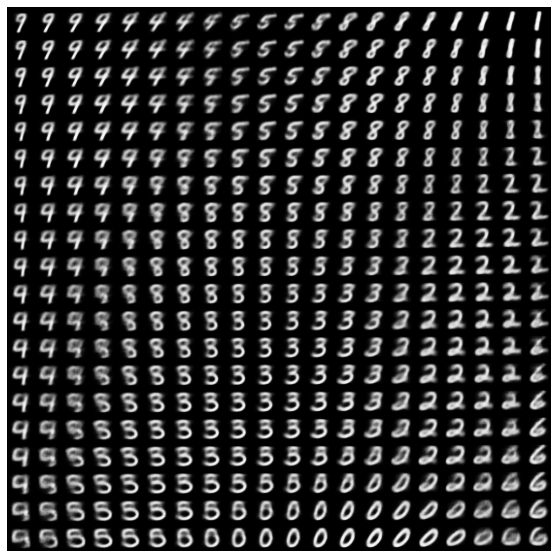

In [32]:
plot_latent_images(vae.model, 20)

Summarize history for loss

In [33]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [34]:
beta_vae_list.keys(), prior_vae_list.keys()

(dict_keys([1.0]), dict_keys([]))

In [35]:
max_beta = max(beta_vae_list.keys())
max_beta

1.0

In [36]:
x = range(1, n_epoch+1)

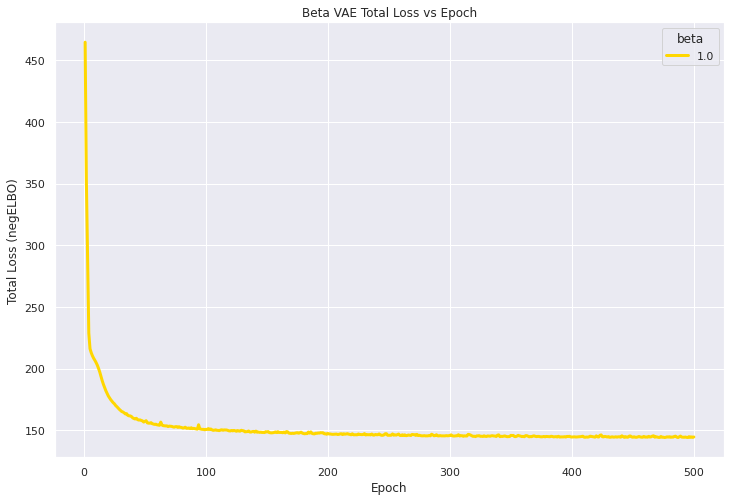

In [47]:
for beta, vae in beta_vae_list.items():
    y = vae.metrics['loss']
    if beta == 1:
        plt.plot(x, y, label=beta, color=lighten_color('gold', 1), lw=3)
    else:
        plt.plot(x, y, label=beta, color=lighten_color('red', (beta-1)/(max_beta-1)))
plt.title('Beta VAE Total Loss vs Epoch')
plt.ylabel('Total Loss (negELBO)')
plt.xlabel('Epoch')
# plt.ylim(ymin=0)
plt.legend(title='beta')
plt.rcParams["figure.figsize"] = (16, 10)
plt.show();

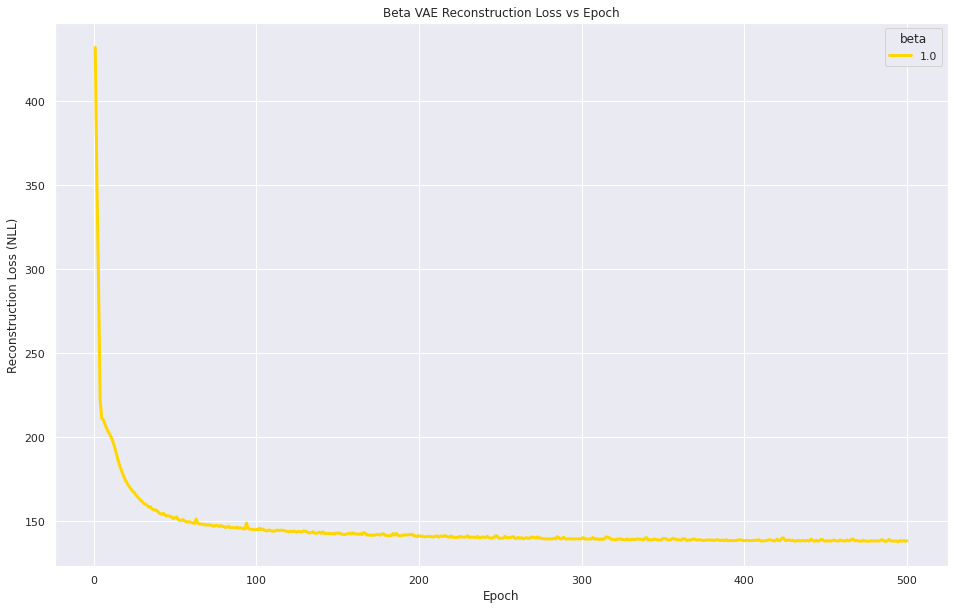

In [48]:
for beta, vae in beta_vae_list.items():
    y = vae.metrics['recon_loss']
    if beta == 1:
        plt.plot(x, y, label=beta, color=lighten_color('gold', 1), lw=3)
    else:
        plt.plot(x, y, label=beta, color=lighten_color('blue', (beta-1)/(max_beta-1)))
plt.title('Beta VAE Reconstruction Loss vs Epoch')
plt.ylabel('Reconstruction Loss (NLL)')
plt.xlabel('Epoch')
# plt.ylim(ymin=0)
plt.legend(title='beta')
plt.rcParams["figure.figsize"] = (16, 10)
plt.show();

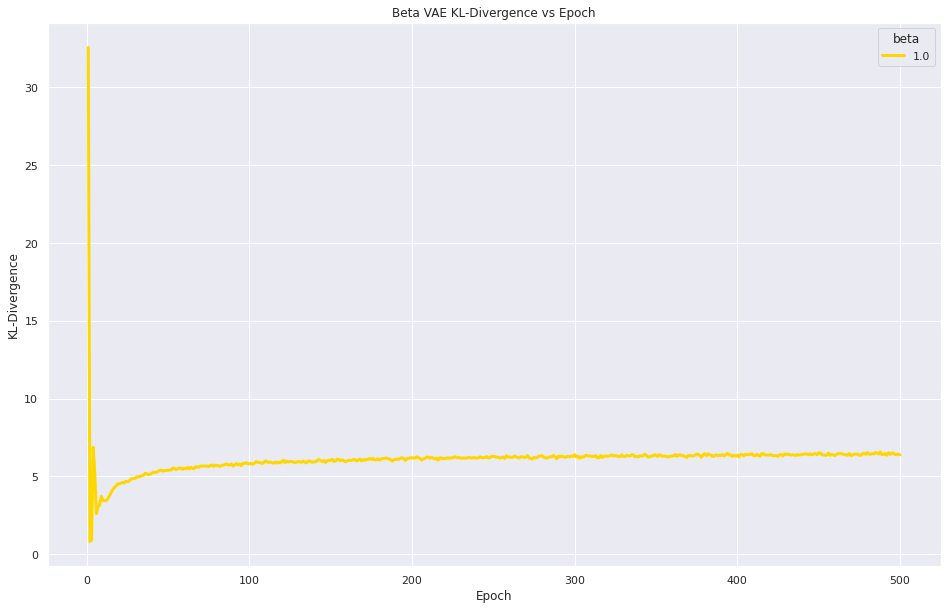

In [49]:
for beta, vae in beta_vae_list.items():
    y = vae.metrics['kl_div']
    if beta == 1:
        plt.plot(x, y, label=beta, color=lighten_color('gold', 1), lw=3)
    else:
        plt.plot(x, y, label=beta, color=lighten_color('purple', (beta-1)/(max_beta-1)))
plt.title('Beta VAE KL-Divergence vs Epoch')
plt.ylabel('KL-Divergence')
plt.xlabel('Epoch')
# plt.ylim(ymin=0)
plt.legend(title='beta')
plt.rcParams["figure.figsize"] = (16, 10)
plt.show();

In [50]:
# prior_vae_list.items()

In [51]:
# for p_std, vae in prior_vae_list.items():
#     y = vae.metrics['loss']
#     if p_std == 1:
#         plt.plot(x, y, label=p_std, color=lighten_color('gold', 1), lw=3)
#     # elif p_std <= 2:
#     #     # continue
#     #     plt.plot(x, y, label=p_std, color=lighten_color('indigo', (p_std-1)/2))
#     else:
#         # continue
#         plt.plot(x, y, label=p_std, color=lighten_color('indigo', (p_std)/3))
# plt.title('VAE Metric vs Epoch')
# plt.ylabel('Metric (-ELBO)')
# plt.xlabel('Epoch')
# # plt.ylim(ymin=0)
# plt.legend(title='prior std')
# plt.rcParams["figure.figsize"] = (16, 10)
# plt.show();

In [52]:
# for p_std, vae in prior_vae_list.items():
#     y = vae.metrics['elbo']
#     plt.plot(x, y, label = int(p_std), color=lighten_color('indigo', p_std/5))
# plt.title('VAE Loss vs Epoch')
# plt.ylabel('Loss (-ELBO)')
# plt.xlabel('Epoch')
# # plt.ylim(ymin=0)
# plt.legend(title='prior std')
# plt.rcParams["figure.figsize"] = (16, 10)
# plt.show();

In [53]:
# plt.plot(range(1, n_epoch+1), vae.metrics['loss'])
# plt.title('Model Loss (-ELBO)')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# # plt.ylim(ymin=0)
# plt.show();